Pilar Navarro Ramírez


#### Código de https://www.kaggle.com/sauravjoshi23/digit-recognition-using-cnn-99-835-acc-top-4

In [ ]:
import pandas as pd
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, MaxPool2D, Conv2D, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import mnist
from keras.utils.np_utils import to_categorical

sns.set(style='white', context='notebook', palette='deep')

%matplotlib inline

## Lectura de los datos y preprocesamiento

In [ ]:
mndata = MNIST('data')

x_train, y_train = mndata.load_training()
x_test, y_test = mndata.load_testing()

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [ ]:
x_train = x_train.reshape((len(x_train),28,28))
x_test = x_test.reshape((len(x_test),28,28))

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
y_train=pd.DataFrame(y_train)

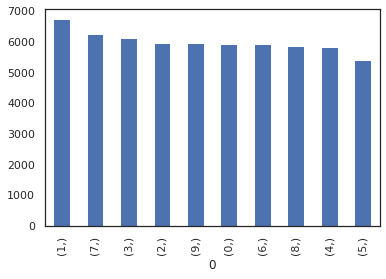

In [ ]:
hist = y_train.value_counts()
hist.plot.bar()

In [ ]:
#normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
#reshape
x_train = x_train.reshape(-1, 28,28,1)
x_test = x_test.reshape(-1, 28,28,1)

In [ ]:
#label encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
y_train[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
#split data into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
print("X_train shape: ", x_train.shape)
print("X_val shape: ", x_val.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (54000, 28, 28, 1)
X_val shape:  (6000, 28, 28, 1)
y_train shape:  (54000, 10)
y_val shape:  (6000, 10)


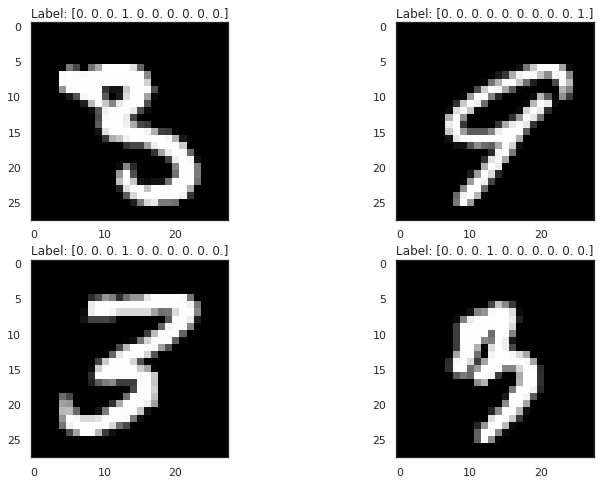

In [ ]:
nrows = 2
ncols = 2

pic_indexes = np.random.randint(x_train.shape[0], size=(nrows*ncols))

f, axs = plt.subplots(nrows, ncols, figsize=(12, 8))
axs = axs.flatten()

picture_index  = 0

for picture_index, ax in zip(pic_indexes, axs):
        ax.imshow(x_train[picture_index].reshape(28, 28), cmap='gray')
        ax.set_title(f'Label: {y_train[picture_index]}')

plt.show()

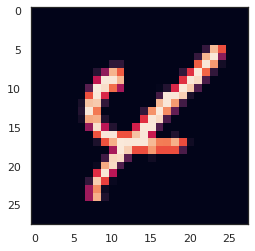

In [ ]:
g = plt.imshow(x_train[0][:,:,0])

## Double CNN

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size = (5,5), padding = 'Same', activation= 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters=32, kernel_size = (5,5), padding = 'Same', activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'Same', activation= 'relu'))
model.add(Conv2D(filters=64, kernel_size = (3,3), padding = 'Same', activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon=1e-08, decay =0.0)

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 64)        

In [ ]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 50 
batch_size = 86
#Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
# Fit the model
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
627/627 - 13s - loss: 0.3560 - accuracy: 0.8885 - val_loss: 0.0531 - val_accuracy: 0.9827
Epoch 2/50
627/627 - 12s - loss: 0.1058 - accuracy: 0.9692 - val_loss: 0.0317 - val_accuracy: 0.9900
Epoch 3/50
627/627 - 12s - loss: 0.0797 - accuracy: 0.9769 - val_loss: 0.0300 - val_accuracy: 0.9912
Epoch 4/50
627/627 - 12s - loss: 0.0692 - accuracy: 0.9797 - val_loss: 0.0281 - val_accuracy: 0.9925
Epoch 5/50
627/627 - 12s - loss: 0.0669 - accuracy: 0.9807 - val_loss: 0.0297 - val_accuracy: 0.9905
Epoch 6/50
627/627 - 12s - loss: 0.0634 - accuracy: 0.9815 - val_loss: 0.0329 - val_accuracy: 0.9905
Epoch 7/50
627/627 - 12s - loss: 0.0659 - accuracy: 0.9820 - val_loss: 0.0248 - val_accuracy: 0.9932
Epoch 8/50
627/627 - 12s - loss: 0.0630 - accuracy: 0.9828 - val_loss: 0.0275 - val_accuracy: 0.9920
Epoch 9/50
627/627 - 12s - loss: 0.0663 - accuracy: 0.9822 - val_loss: 0.0283 - val_accuracy: 0.9918
Epoch 10/50
627/627 - 12s - loss: 0.0652 - accuracy: 0.9821 - val_loss: 0.0273 - val_accura

In [ ]:
# Confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Resultados

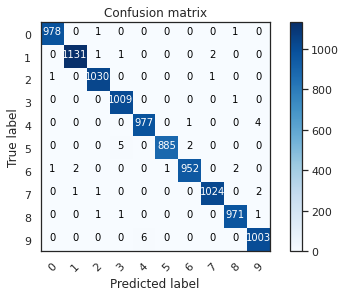

In [ ]:
# Predict the values from the test dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)
print("Test Accuracy: ",score[1])

Test Accuracy:  0.9959999918937683


## Triple CNN

In [ ]:
def get_newtriplecnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = (28,28,1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
          
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
            
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(10, activation = "softmax")
        
    ])

In [ ]:
model = get_newtriplecnn()
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 14, 14, 64)      

In [ ]:
#adding callbacks
callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('model.best.hdf5', save_best_only=True) # saving the best model
]

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = 50, 
                               steps_per_epoch = x_train.shape[0] // batch_size,
                               validation_data = (x_val, y_val),
                               callbacks = callbacks1)

Epoch 1/50
627/627 [==============================] - 17s 25ms/step - loss: 1.1428 - accuracy: 0.6335 - val_loss: 0.0817 - val_accuracy: 0.9757
Epoch 2/50
627/627 [==============================] - 15s 25ms/step - loss: 0.1501 - accuracy: 0.9585 - val_loss: 0.0496 - val_accuracy: 0.9855
Epoch 3/50
627/627 [==============================] - 15s 25ms/step - loss: 0.1061 - accuracy: 0.9688 - val_loss: 0.0359 - val_accuracy: 0.9897
Epoch 4/50
627/627 [==============================] - 15s 25ms/step - loss: 0.0875 - accuracy: 0.9739 - val_loss: 0.0387 - val_accuracy: 0.9888
Epoch 5/50
627/627 [==============================] - 15s 24ms/step - loss: 0.0799 - accuracy: 0.9783 - val_loss: 0.0424 - val_accuracy: 0.9872
Epoch 6/50
627/627 [==============================] - 15s 24ms/step - loss: 0.0678 - accuracy: 0.9810 - val_loss: 0.0319 - val_accuracy: 0.9917
Epoch 7/50
627/627 [==============================] - 15s 25ms/step - loss: 0.0627 - accuracy: 0.9818 - val_loss: 0.0451 - val_accuracy:

### Resultados

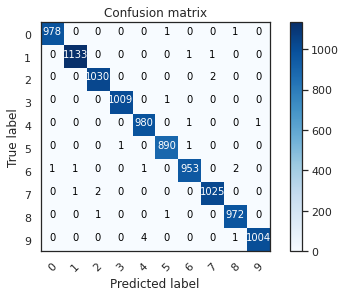

In [ ]:
# Predict the values from the test dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)
print("Test Accuracy: ",score[1])

Test Accuracy:  0.9973999857902527


In [ ]:
result = model.predict(x_test)

result = np.argmax(result, axis=1)

result = pd.Series(result, name='Label')

result.head()

0    7
1    2
2    1
3    0
4    4
Name: Label, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data) Number of Digits classes predicted')

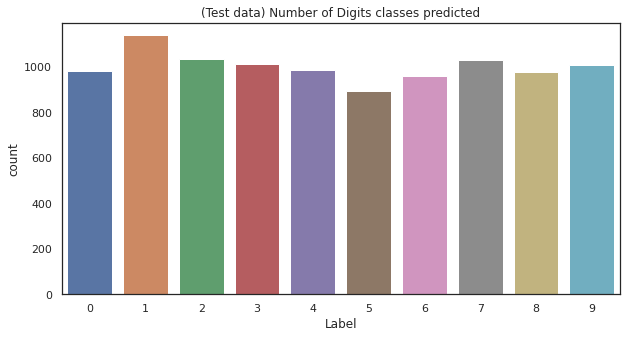

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(result)
plt.title("(Test data) Number of Digits classes predicted")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '(Test data) Number of Digits classes real')

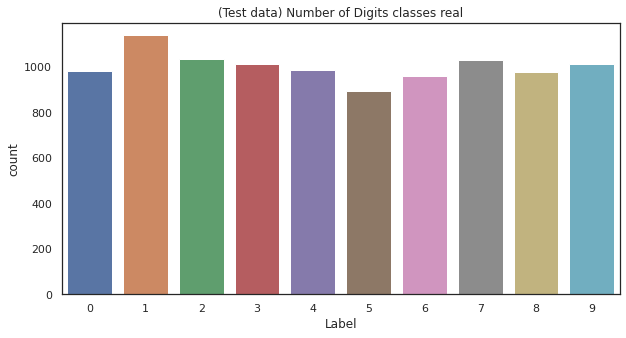

In [ ]:
plt.figure(figsize=(10,5))
y_true = pd.Series(y_true, name='Label')
sns.countplot(y_true)
plt.title("(Test data) Number of Digits classes real")